# RUN

In [18]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from nilearn.decoding import Decoder
from nilearn import plotting


from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 

import sys
import os, warnings

from fonction import *
from run_ import *

# Load data

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Mask data

Shape of the mask:  (91, 109, 91)


/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


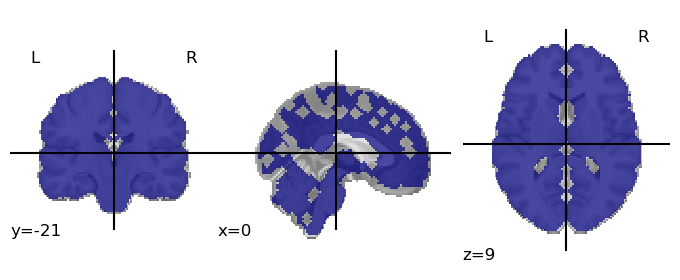

In [4]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

In [5]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|███████████████████████████████████████████| 49/49 [00:17<00:00,  2.87it/s]


In [6]:
print("We have 49 subjects, and for each of them there are 30 beta maps. Hence we have", samples.shape[0],
      "observations and",  samples.shape[1], "features")

We have 49 subjects, and for each of them there are 30 beta maps. Hence we have 1470 observations and 216734 features


# Labels

In [7]:
random.seed(42)

In [8]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


In [9]:
train_samples, test_samples, train_labels, test_labels = split(samples, labels, 4)

Test sample shape (120, 216734) , label size :  120
Train sample shape (1350, 216734) , label size :  1350


# Classification

# Part 1 - Simple MVPA approach 

Evaluation of model and cross fold strategy to predict condition (just evluate that all vowels in the mask allow the classification of the condition).

2 models : 
- Logistic Classifier : with mutlinomial
- SVC : with ovr (one vs the rest)

3 CV strategy : 
- 5-fold CV
- leave 1 run out across all subjects
- leave a set of subject (7*9) across all subject 


https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

--> All model evaluate with Accuracy

In [ ]:
chunks_CV = {}
for key in ['per_9subjects', 'per_run'] :
    chunks_CV[key]=eval('make_chunks_'+key)()
    

# ---------------PAS run---------

## Baseline Models

In [12]:
classifiers = {'logistic': LogisticRegression(multi_class="multinomial", max_iter=50), 'svc' : LinearSVC(max_iter=50)}

In [35]:
warnings.filterwarnings("ignore")
dic_cv_scores={}
baseline_run(classifiers, chunks_CV, train_samples, train_labels, dic_cv_scores)


logistic, 5fold_CV :


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Average accuracy = 0.78 

Average Accuracy std = 0.04 

Accuracy per fold:
[0.72222222 0.76296296 0.80740741 0.77407407 0.82222222]

logistic,per_9subjects :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Average accuracy = 0.78 

Average Accuracy std = 0.02 

Accuracy per fold:
[0.78148148 0.82222222 0.78148148 0.74814815 0.78888889]

logistic,per_run :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Average accuracy = 0.81 

Average Accuracy std = 0.03 

Accuracy per fold:
[0.76296296 0.86296296 0.81111111 0.81111111 0.81851852]

svc, 5fold_CV :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 56.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Average accuracy = 0.69 

Average Accuracy std = 0.03 

Accuracy per fold:
[0.62592593 0.68518519 0.71481481 0.7        0.71111111]

svc,per_9subjects :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Average accuracy = 0.71 

Average Accuracy std = 0.05 

Accuracy per fold:
[0.75555556 0.74074074 0.74074074 0.61111111 0.69259259]

svc,per_run :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min finished


Average accuracy = 0.73 

Average Accuracy std = 0.04 

Accuracy per fold:
[0.65555556 0.75925926 0.74074074 0.75185185 0.75555556]


### Visualisation

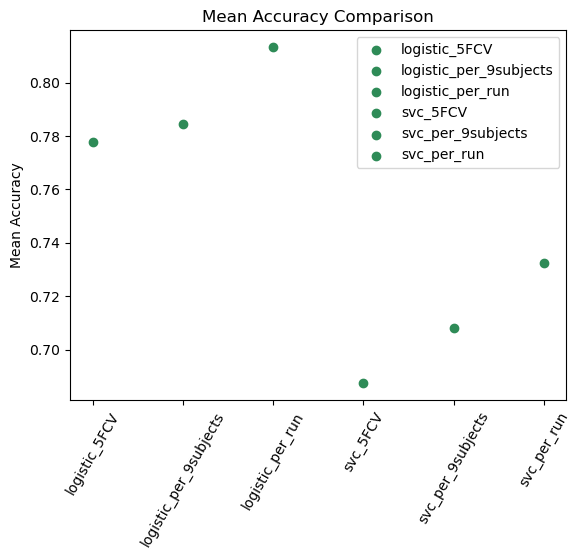

In [58]:
for key,mean in dic_cv_scores.items():
    plt.scatter(key,mean,color='seagreen')
    
plt.xticks(rotation=60)
plt.title('Mean Accuracy Comparison')
plt.ylabel('Mean Accuracy')
plt.show()

### Evaluation on test data

Test accuracy Score for  logistic  :  0.7416666666666667 



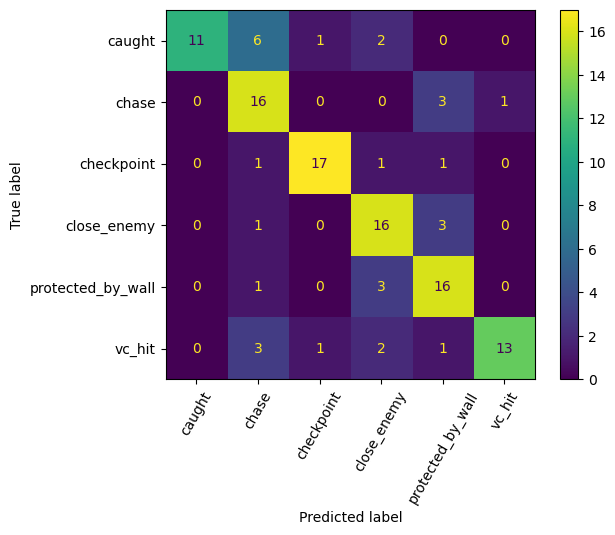

Test accuracy Score for  svc  :  0.6416666666666667 



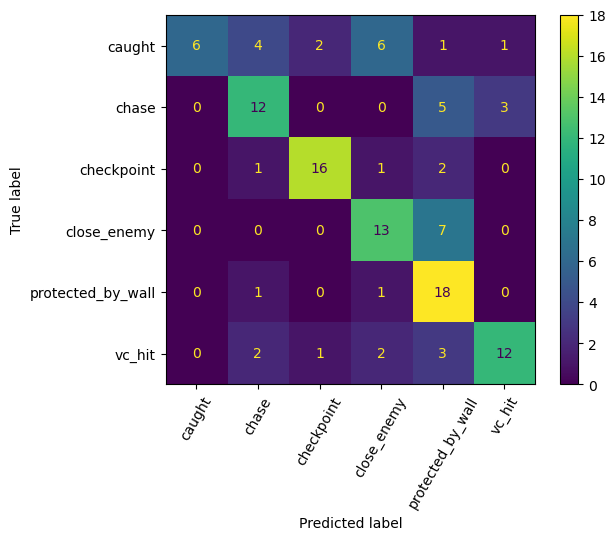

In [64]:
test_baseline(train_samples,test_samples,train_labels, test_labels,classifiers)

*Conclusion* : The logistic Classifier works faster, and achieve better classification with all CV strategies but also with the testdataset. Hence, we will conitnue only with it and try to improve the accuracy by tunning the hyperparameters and test for feqtures extraction.

# ------RUN-------

## Tuned Model

- Tuned penalty hyperparameter without features extraction
- Tuned penalty hyperparameter with features extraction

In [10]:
logic_score={}
gid_logistic = {'logistic__C' : [1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]}

In [ ]:
pipe = Pipeline([('scale', StandardScaler()), ('logistic', LogisticRegression(multi_class="multinomial",max_iter=50))])
tuned_run(pipe, gid_logistic,chunks_CV, train_samples, train_labels, '_tuned', logic_score, 'logistic')

In [ ]:
pipe = Pipeline([('scale', StandardScaler()),('pca',PCA(n_components=150)), ('logistic', LogisticRegression(multi_class="multinomial", max_iter=50))])
tuned_run(pipe, gid_logistic,chunks_CV, train_samples, train_labels, 'PCA_tuned', logic_score, 'logistic')

### Visualisation

In [ ]:
for key,mean in logic_score.items():
    plt.scatter(key,mean,color='seagreen')
    
plt.xticks(rotation=60)
plt.title('Mean Accuracy Comparison')
plt.ylabel('Mean Accuracy')
plt.show()

## Verifie que c'est les même paramètres

## Evaluation of the Best Model : Permutation Test

---> compare the accuracy value of the correct labels to the ones with random/false labels

In [ ]:
clf= LogisticRegression(multi_class="multinomial", max_iter=50, C=1e-5)
pipeline = Pipeline([('scale', StandardScaler()), ('logistic', clf)])

In [ ]:
evaluation_test(pipeline, train_samples, train_labels, LeaveOneGroupOut(), chunks_CV['per_run'])

In [ ]:
pipe = Pipeline([('scale', StandardScaler()),('pca',PCA(n_components=150)),
                 ('logistic', LogisticRegression(multi_class="multinomial", max_iter=50, C=0.0001))])

In [ ]:
evaluation_test(pipe,train_samples, train_labels, chunks_CV['per_run'])

*NB* :  p-value --> the lower the better  : bc it's indicate that there's a dependency btw the features & targets which has been used by the estimator to give good prediction.

# -------- FINIS RUN------

*Conclusion* : use CV with per_run 

# 2nd Part  : Decoding
With the best model & CV strategy selected above, we now search for visualisaing which area of the brain is involved into the condition. 
https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_decoding_tutorial.html#sphx-glr-auto-examples-00-tutorials-plot-decoding-tutorial-py

In [13]:
beta_maps_test = nib.funcs.concat_images(beta_maps[0:4], axis = -1)
beta_maps_train = nib.funcs.concat_images(beta_maps[4:49], axis = -1)
labels_test = labels[:120]
labels_train = labels[120:,]

In [25]:
best_grid = {'C': [1e-5], 
             'solver' : ['lbfgs'], 
             'multi_class':['multinomial'],
             'max_iter':[50] }

In [26]:
decoder = Decoder(estimator= 'logistic',mask= mask, param_grid=best_grid, cv=LeaveOneGroupOut()
                  ,scoring='accuracy', standardize = True)

decoder.fit(beta_maps_train, train_labels, chunks_CV['per_run'])

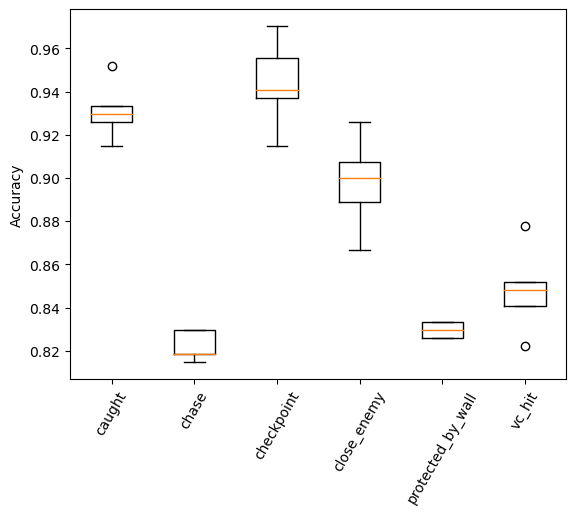

In [45]:
fig, ax = plt.subplots()
ax.boxplot(decoder.cv_scores_.values())
ax.set_xticklabels(decoder.cv_scores_.keys())
plt.xticks(rotation=60)
plt.ylabel('Accuracy')
plt.show()

Test accuracy Score  :  0.725 



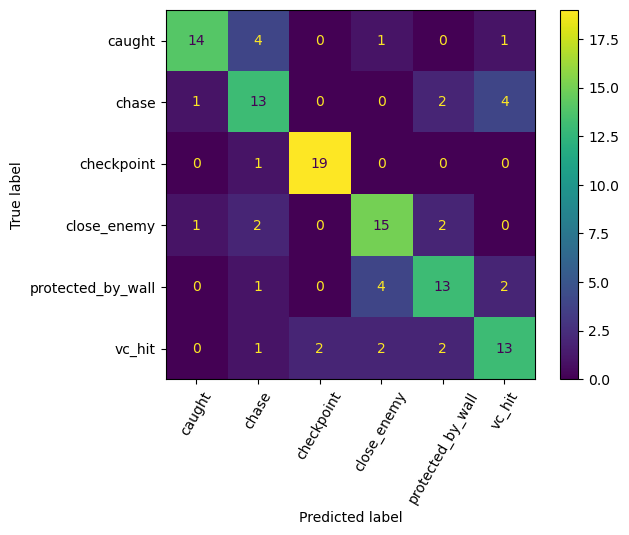

In [28]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
acc =accuracy_score(labels_test, test_pred)
print('Test accuracy Score  : ',  acc, '\n')   
cm=confusion_matrix(labels_test, test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decoder.classes_)
disp.plot()
plt.xticks(rotation=60)
plt.show()


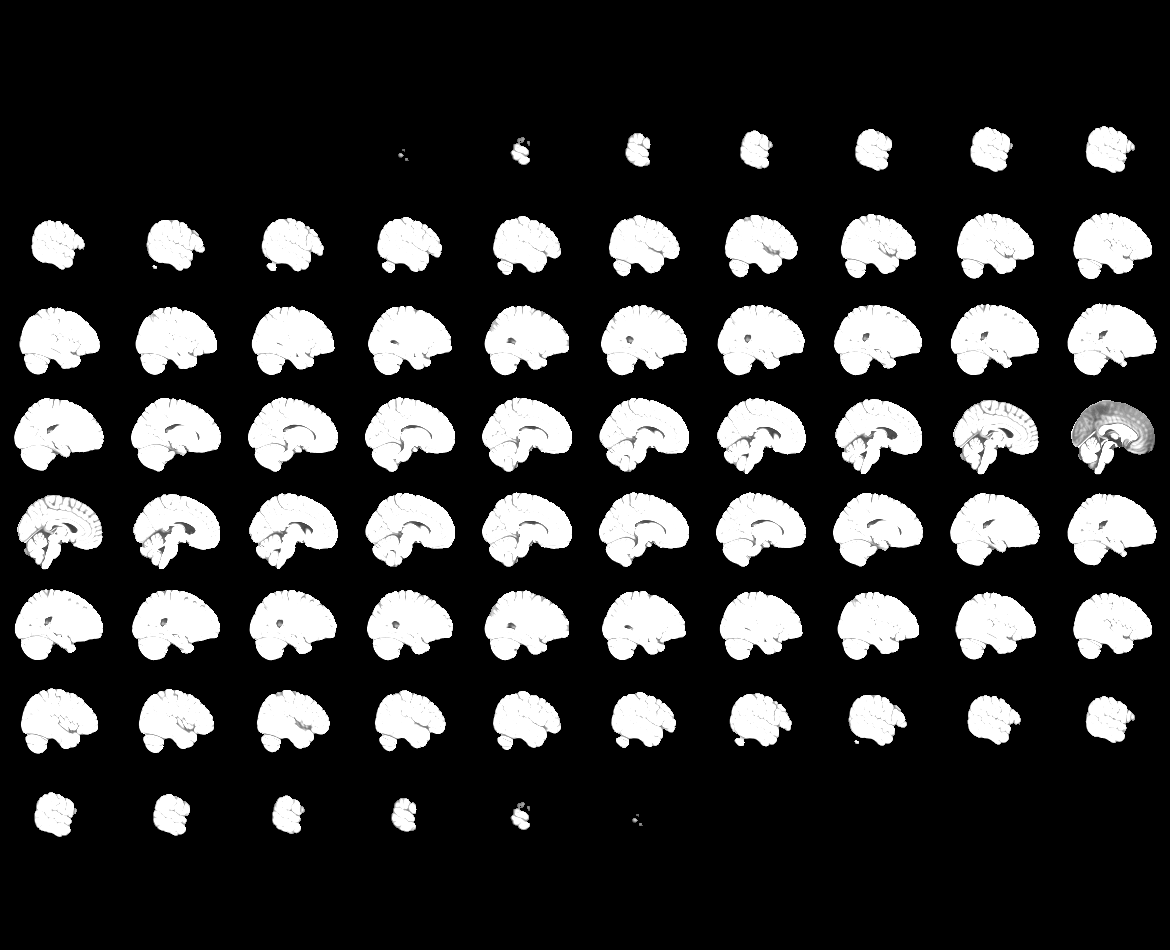
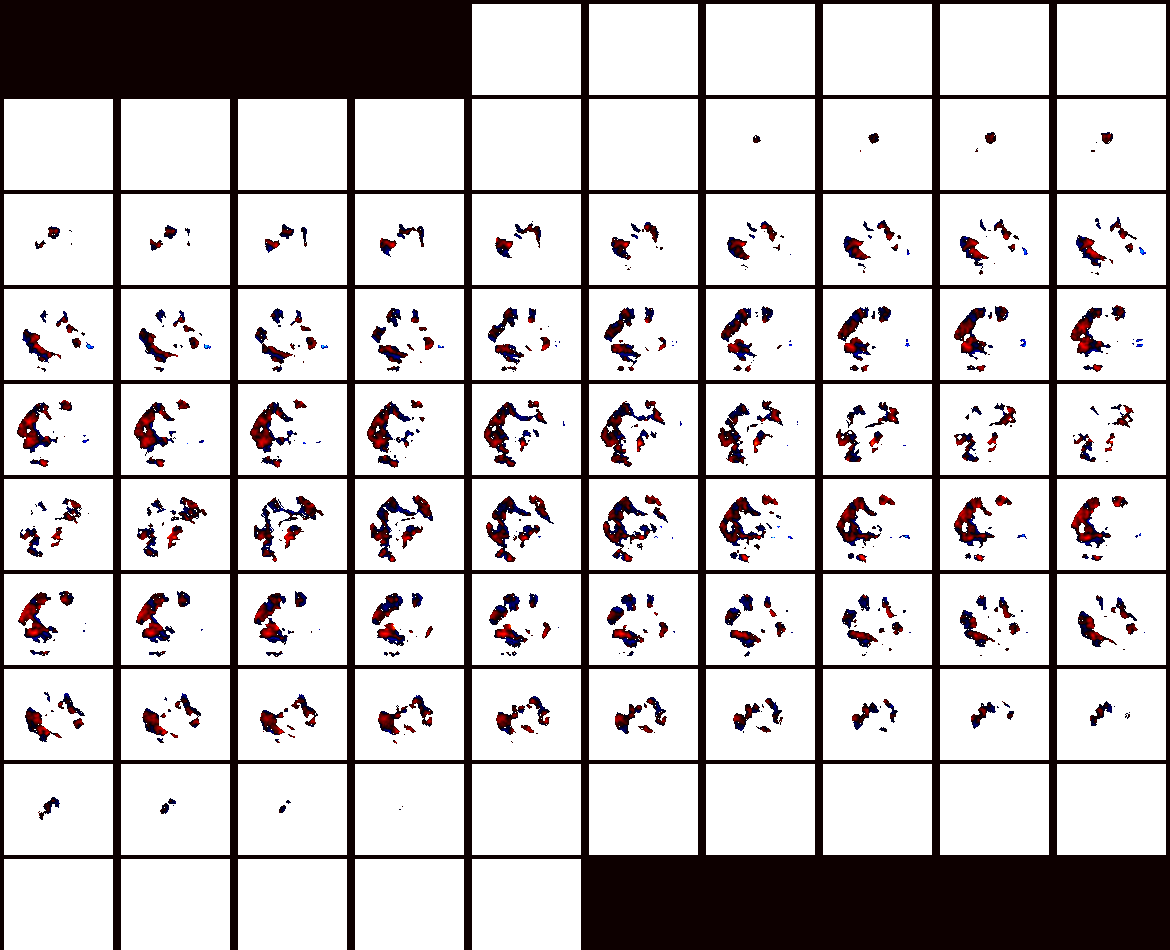

In [29]:
plotting.view_img(decoder.coef_img_['caught'],title="caught Logistic weights", dim=-1)


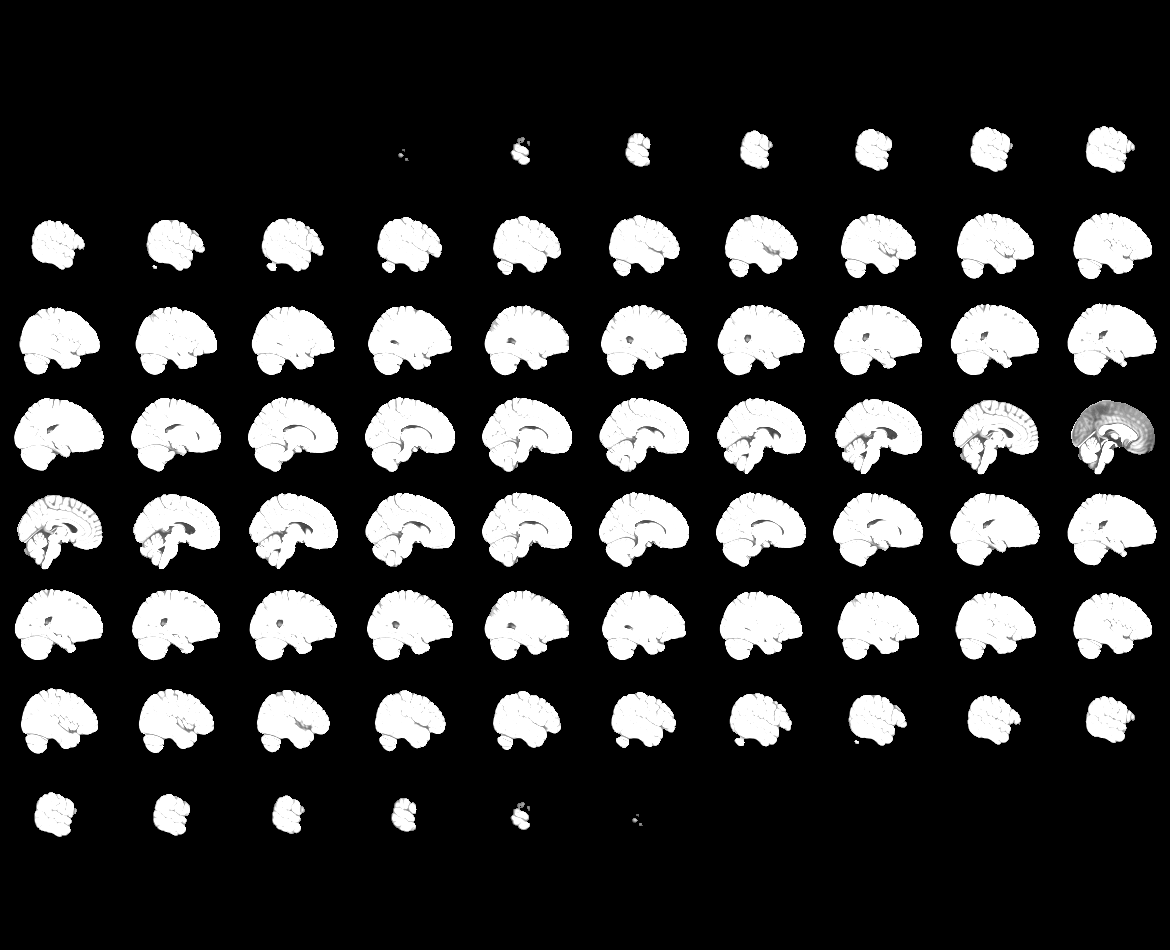
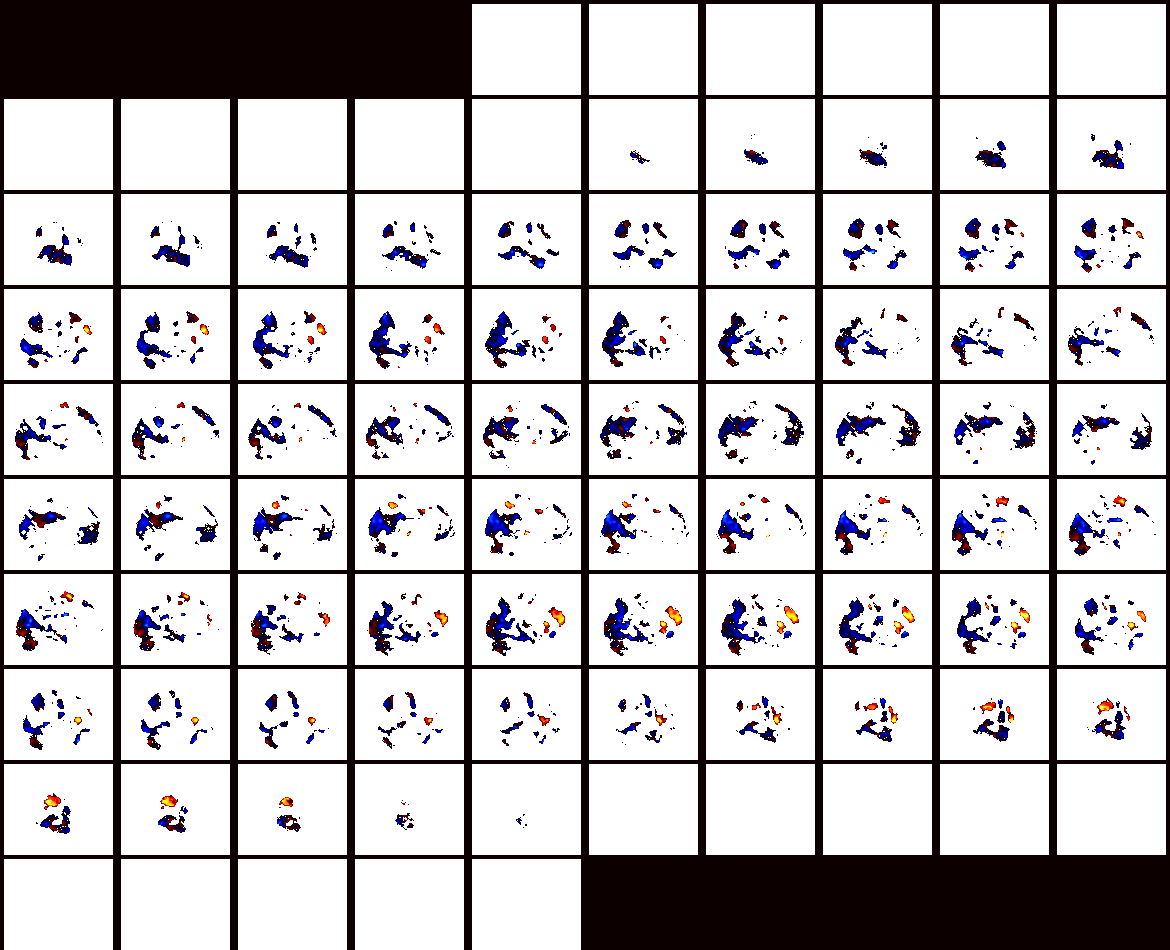

In [30]:
plotting.view_img(decoder.coef_img_['chase'],title="chase Logistic weights", dim=-1)


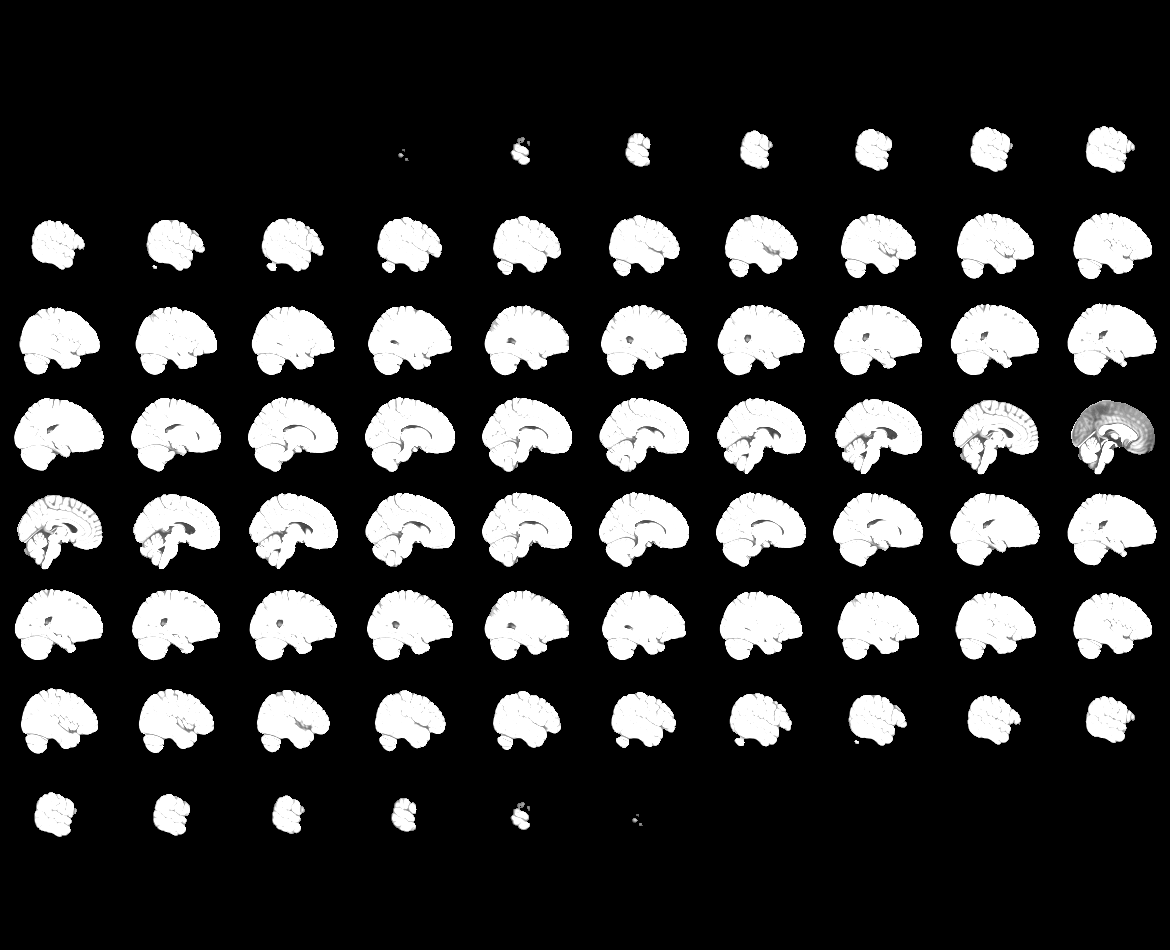
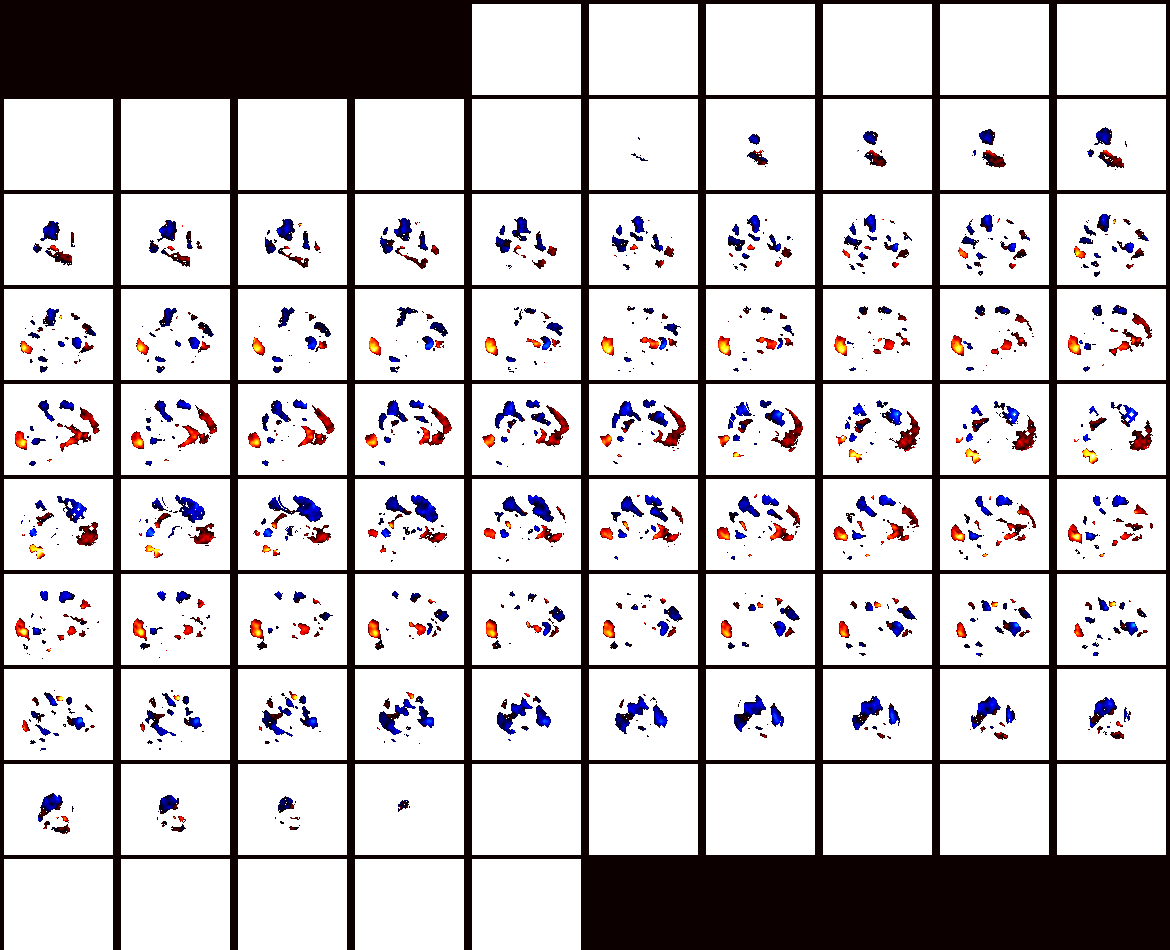

In [31]:
plotting.view_img(decoder.coef_img_['checkpoint'],title=" checkpoint Logistic weights", dim=-1)


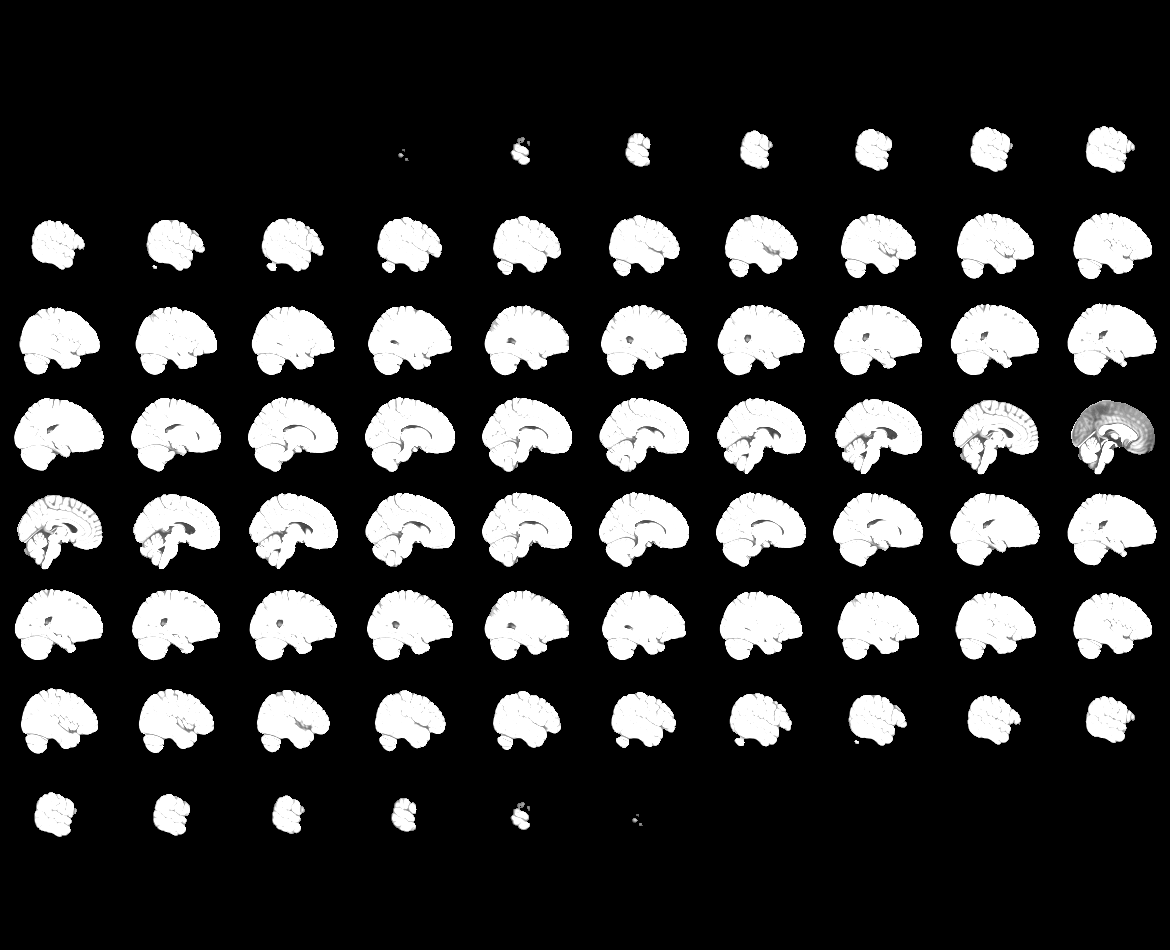
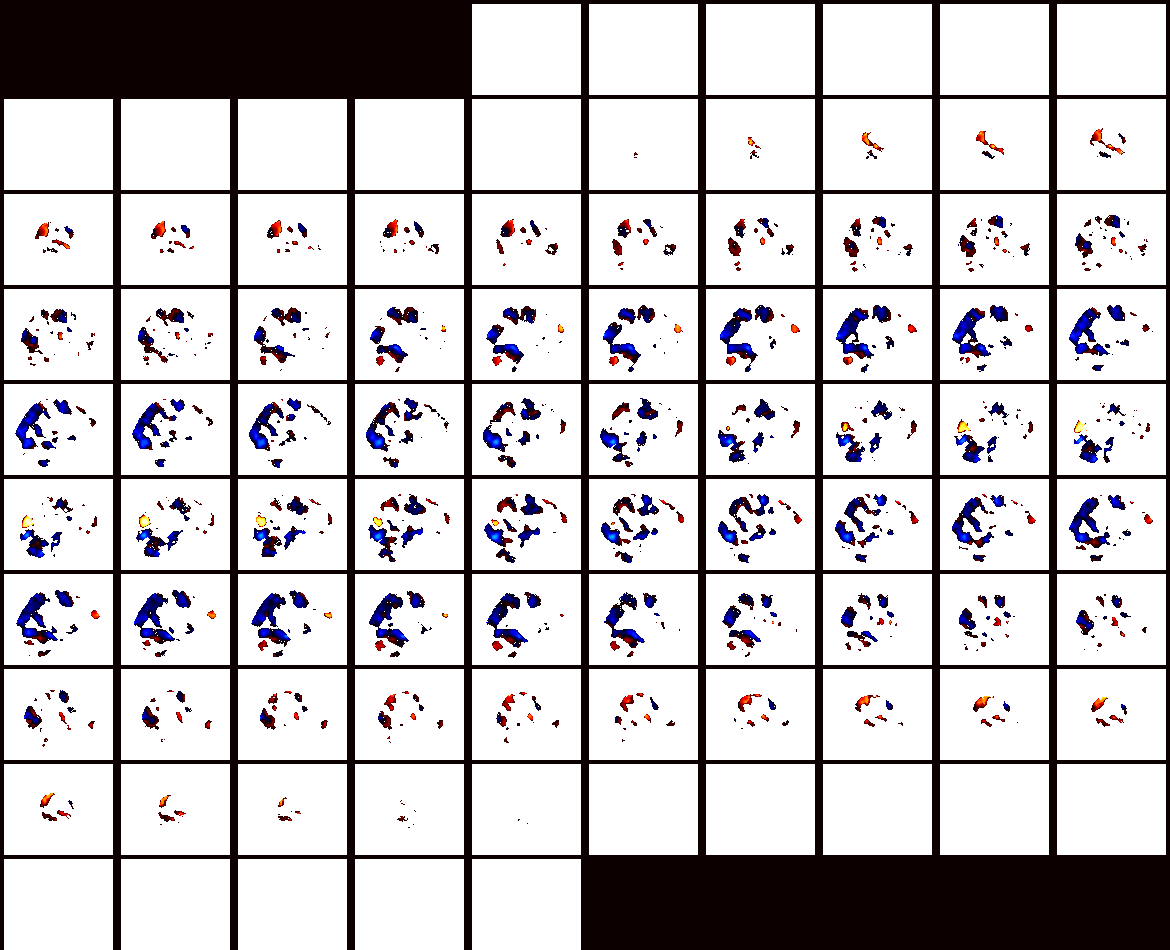

In [32]:
plotting.view_img(decoder.coef_img_['close_enemy'],title=" close_enemy Logistic weights", dim=-1)


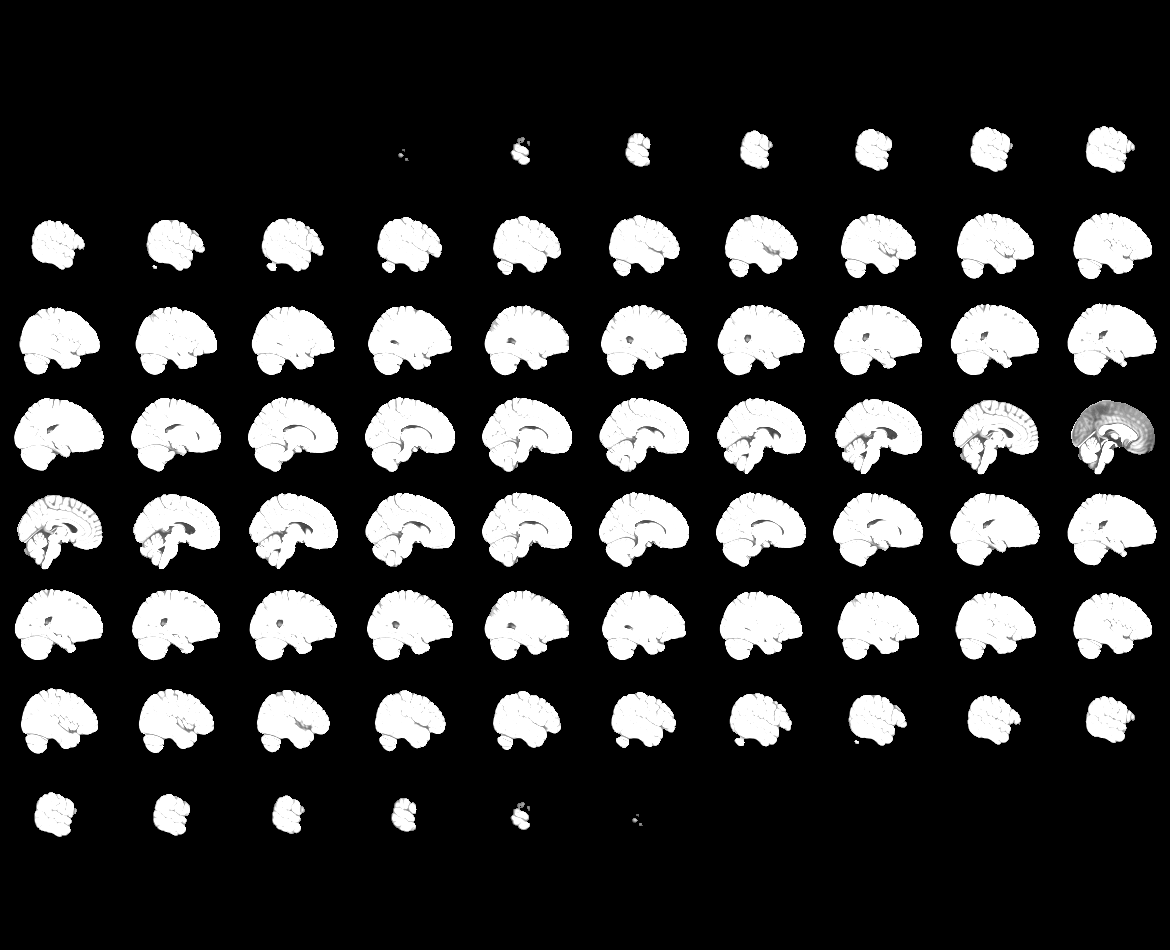
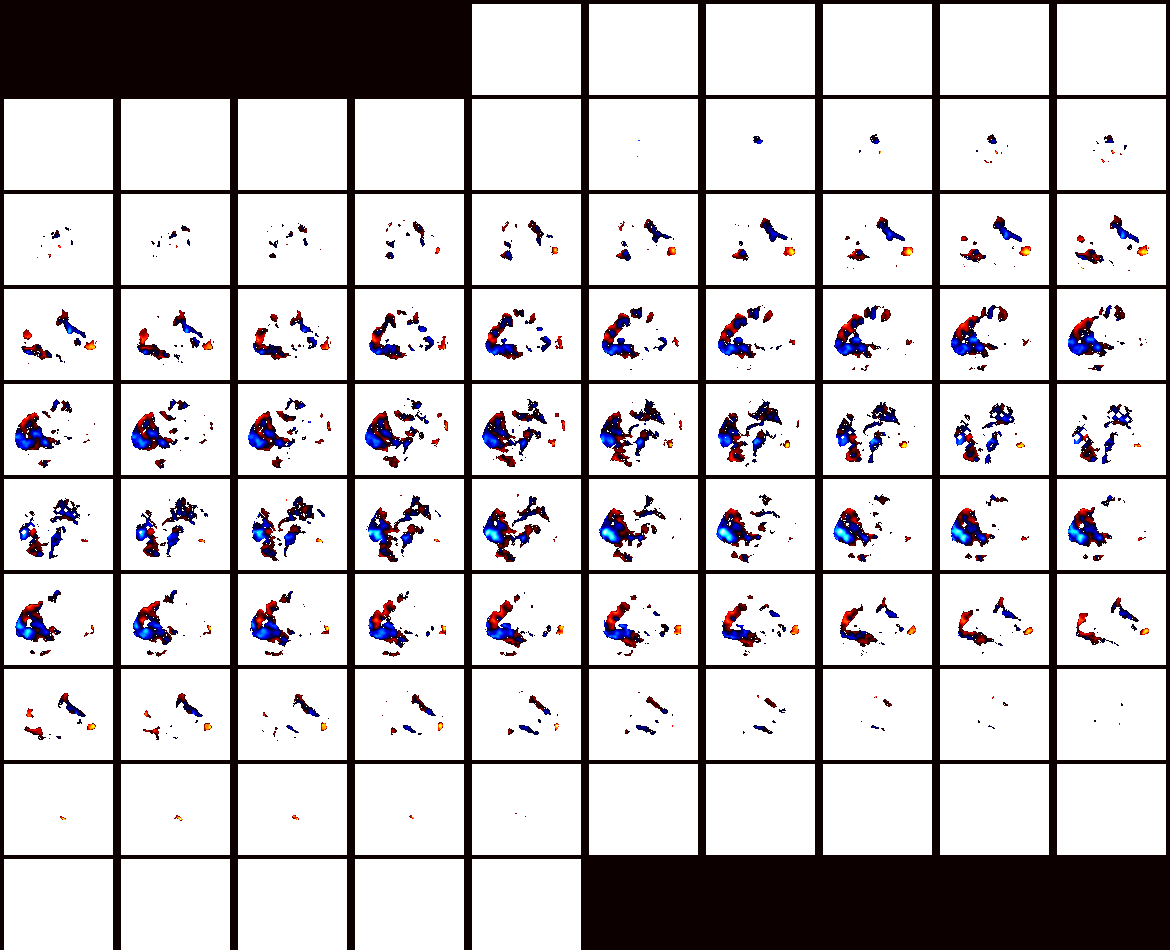

In [33]:
plotting.view_img(decoder.coef_img_['protected_by_wall'], title=" Protected_by_wall Logstic weights", dim=-1)

## Verify it performs better than a dummy classifier 

In [35]:
warnings.simplefilter("ignore")
dummy_decoder = Decoder(estimator='dummy_classifier', mask=mask,
                        cv=LeaveOneGroupOut(),scoring='accuracy', standardize = True)

{'caught': [0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222], 'chase': [0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445], 'checkpoint': [0.7518518518518519, 0.7518518518518519, 0.7518518518518519, 0.7518518518518519, 0.7518518518518519], 'close_enemy': [0.7296296296296296, 0.7296296296296296, 0.7296296296296296, 0.7296296296296296, 0.7296296296296296], 'protected_by_wall': [0.7148148148148148, 0.7148148148148148, 0.7148148148148148, 0.7148148148148148, 0.7148148148148148], 'vc_hit': [0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445]}


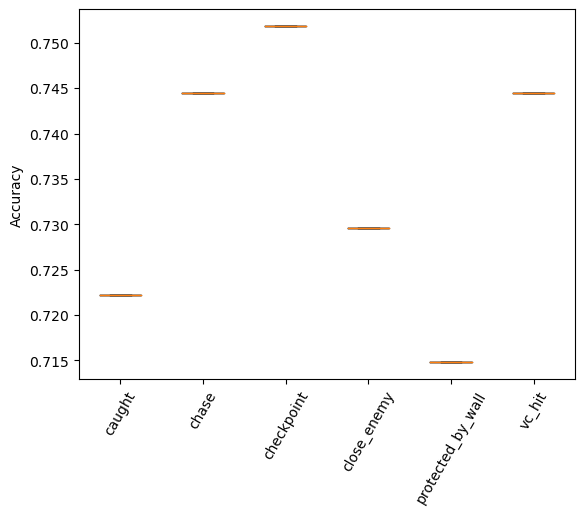

In [50]:
fig, ax = plt.subplots()
ax.boxplot(dummy_decoder.cv_scores_.values())
ax.set_xticklabels(dummy_decoder.cv_scores_.keys())
plt.xticks(rotation=60)
plt.ylabel('Accuracy')
plt.show()

Test accuracy Score  :  0.21666666666666667 



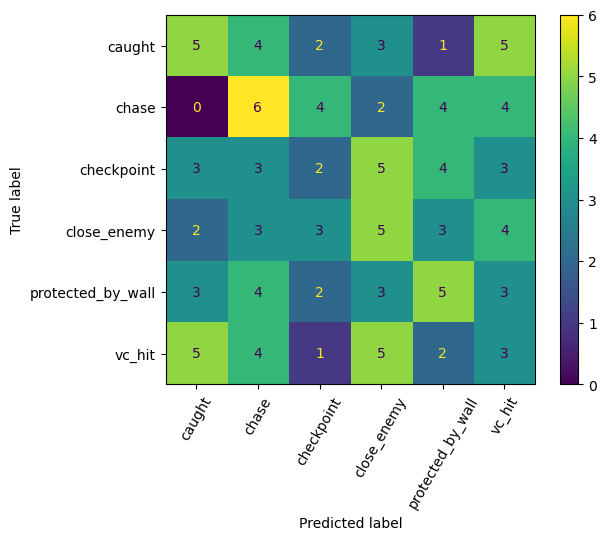

In [36]:
test_pred = dummy_decoder.predict(beta_maps_test)
acc_dummy=accuracy_score(labels_test, test_pred)
print('Test accuracy Score  : ',  acc_dummy, '\n')   
cm=confusion_matrix(labels_test, test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_decoder.classes_)
disp.plot()
plt.xticks(rotation=60)
plt.show()